**First Test for the subject C10 of the optimisation in data analysis courses**

In [1]:
# Check if cuda is avaible for GPU acceleartion
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Use of :", device)

Use of : cuda


Testing of the algorithm Dual Coordinate Descent with L2-SVM without any optimisation (section 2 of the article)

In [2]:
# Definition of the function

import numpy as np

def dual_coordinate_descent_l2_svm(X, y, C=1.0, tol=1e-3, max_iter=100):
    """
    Dual Coordinate Descent algorithm implementation for L2-SVM
    X : (l x n) feature matrix
    y : (l,) label vector {-1, +1}
    C : regularization parameter
    tol : convergence tolerance
    max_iter : maximum number of outer iterations
    """
    l, n = X.shape
    alpha = np.zeros(l)
    w = np.zeros(n)
    D = 1 / (2 * C)  # L2-SVM => Dii = 1/(2C)

    for it in range(max_iter):
        alpha_old = alpha.copy()

        for i in np.random.permutation(l):  # random permutation
            xi = X[i]
            yi = y[i]

            G = yi * np.dot(w, xi) - 1 + D * alpha[i]

            # Projected gradient
            if alpha[i] == 0 and G >= 0:
                continue
            elif alpha[i] == np.inf and G <= 0:
                continue
            elif 0 < alpha[i] < np.inf and abs(G) < tol:
                continue

            # Update alpha_i
            Qii = np.dot(xi, xi) + D
            alpha_i_old = alpha[i]
            alpha[i] = alpha[i] - G / Qii
            # No upper bound for L2-SVM (U = ∞), but we ensure alpha[i] ≥ 0
            alpha[i] = max(alpha[i], 0)

            # Update w
            w += (alpha[i] - alpha_i_old) * yi * xi

        # Simple stopping criterion (change in alphas)
        diff = np.linalg.norm(alpha - alpha_old)
        if diff < tol:
            print(f"Convergence reached at iteration {it}")
            break

    return w, alpha


In [3]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Generate simple synthetic data
X, y = make_classification(n_samples=100, n_features=10, n_informative=5)
y = 2 * (y - 0.5)  # Convert labels from {0,1} to {-1, +1}

# Standardize features
X = StandardScaler().fit_transform(X)

# Run the algorithm
w, alpha = dual_coordinate_descent_l2_svm(X, y, C=1.0)

# Make predictions
preds = np.sign(X @ w)
accuracy = np.mean(preds == y)
print("Accuracy:", accuracy)

Accuracy: 0.84


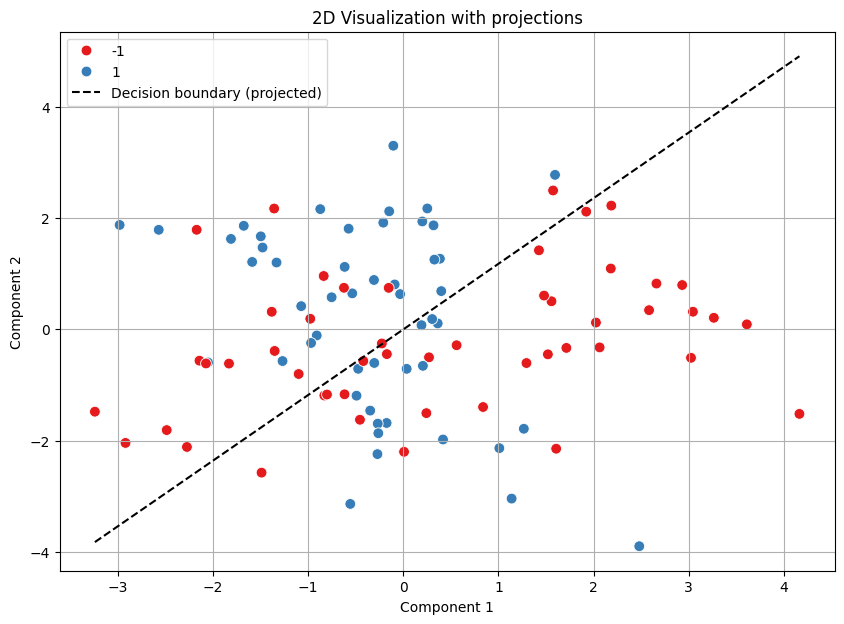

In [5]:
# Visualisation of Dataset + results

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Project the vector w into the reduced (2D) space
w_2d = pca.transform([w])[0]  # projection of w into the same PCA space

# Prepare data for plotting
df = pd.DataFrame({
    'PC1': X_2d[:, 0],
    'PC2': X_2d[:, 1],
    'Label': y.astype(int)
})

# Plot the data points using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Label', palette='Set1', s=60)

# Plot the hyperplane: 
slope = -w_2d[0] / w_2d[1] if w_2d[1] != 0 else 0
x_vals = np.linspace(df['PC1'].min(), df['PC1'].max(), 100)
y_vals = slope * x_vals

plt.plot(x_vals, y_vals, '--', color='black', label='Decision boundary (projected)')
plt.title("2D Visualization with projections")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()